In [1]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False
import timeit
start = timeit.default_timer()


In [2]:
# Define a function to calculate concentration change!
def Cal_new_con_for_Li_EC(Sol,Para,c_EC_0,c_e_0):
    #############################################################################################################################  
    ###############################           Step-1 Prepare parameters:        #################################################
    #############################################################################################################################  
    L_p   =Para["Positive electrode thickness [m]"]
    L_n   =Para["Negative electrode thickness [m]"]
    L_s   =Para["Separator thickness [m]"]
    L_y   =Para["Electrode width [m]"]   # Also update to change A_cc and therefore Q
    L_z   =Para["Electrode height [m]"]
    # Initial EC concentration  
    Ini_Ce_EC        =Para["Bulk solvent concentration [mol.m-3]"]  # Be careful when multiplying with pore volume to get amount in mole. Because of electrolyte dry out, that will give more amount than real.   
    # LLI due to electrode,Ratio of EC and lithium is 1:1 -> EC amount consumed is LLINegSEI[-1]
    LLINegSEI = Sol["Loss of lithium to SEI [mol]"].entries[-1] - Sol["Loss of lithium to SEI [mol]"].entries[0]
    # Pore volume change with time:
    PoreVolNeg = Sol["X-averaged negative electrode porosity"].entries*L_n*L_y*L_z;
    PoreVolSep = Sol["X-averaged separator porosity"].entries*L_s*L_y*L_z;
    PoreVolPos = Sol["X-averaged positive electrode porosity"].entries*L_p*L_y*L_z;
    #############################################################################################################################  
    #####################       Step-2 Determine How much electrolyte is added, whether dry out:        #########################
    #############################################################################################################################  
    Vol_Elely_Tot_old = Para["Current total electrolyte volume in whole cell [m3]"] 
    Vol_Elely_JR_old  = Para["Current total electrolyte volume in jelly roll [m3]"] 
    Vol_Pore_tot_old  = PoreVolNeg[0] + PoreVolSep[0] + PoreVolPos[0]       # pore volume at start time of the run
    Vol_Pore_tot_new  = PoreVolNeg[-1] + PoreVolSep[-1] + PoreVolPos[-1]    # pore volume at end   time of the run, intrinsic variable 
    Vol_Pore_decrease = Vol_Pore_tot_old  - Vol_Pore_tot_new;
    # EC:lithium:SEI=2:2:1     for SEI=(CH2OCO2Li)2
    # Because inner and outer SEI partial molar volume is the same, just set one for whole SEI
    VmolSEI   = Para["Outer SEI partial molar volume [m3.mol-1]"] # 9.8e-5,
    VmolEC    = 6.667e-5  # Unit:m3.mol-1; According to Wiki, correct value: EC molar volume is :66.67 cm3.mol-1  = 6.667e-5, 
    Vol_EC_consumed  = LLINegSEI * VmolEC * 2
    Vol_Elely_need   = Vol_EC_consumed - Vol_Pore_decrease
    Vol_SEI_increase = 0.5*LLINegSEI*VmolSEI   #  volume increase due to SEI
    Test_V = Vol_SEI_increase - Vol_Pore_decrease  #  This value should always be zero, but now not, which becomes the source of error!
    # Important: Calculate added electrolyte based on excessive electrolyte, can be: 1) added as required; 2) added some, but less than required; 3) added 0 
    if Vol_Elely_Tot_old > Vol_Elely_JR_old:                             # This means Vol_Elely_JR_old = Vol_Pore_tot_old ()
        if Vol_Elely_Tot_old-Vol_Elely_JR_old >= Vol_Elely_need:         # 1) added as required
            Vol_Elely_add     = Vol_Elely_need;
            Vol_Elely_Tot_new = Vol_Elely_Tot_old -  Vol_EC_consumed;
            Vol_Elely_JR_new  = Vol_Elely_JR_old  -  Vol_Pore_decrease;  # also equals to 'Vol_Pore_tot_new', or Vol_Pore_tot_old - Vol_Pore_decrease
            Ratio_Dryout = 1.0;
        else:                                                            # 2) added some, but less than required;                                                         
            Vol_Elely_add     = Vol_Elely_Tot_old - Vol_Elely_JR_old;   
            Vol_Elely_Tot_new = Vol_Elely_Tot_old - Vol_EC_consumed;
            Vol_Elely_JR_new  = Vol_Elely_Tot_new;                       # This means Vol_Elely_JR_new <= Vol_Pore_tot_new
            Ratio_Dryout = Vol_Elely_JR_new/Vol_Pore_tot_new;
    else:                                                                # 3) added 0 
        Vol_Elely_add = 0;
        Vol_Elely_Tot_new = Vol_Elely_Tot_old - Vol_EC_consumed;
        Vol_Elely_JR_new  = Vol_Elely_Tot_new; 
        Ratio_Dryout = Vol_Elely_JR_new/Vol_Pore_tot_new;
    #############################################################################################################################  
    ###################       Step-3 Electrolyte mixing, define ratio change for Li and EC concentration        #################
    #############################################################################################################################     
    # Next: start mix electrolyte based on previous defined equation
    # Lithium amount in liquid phase, at initial time point
    TotLi_Elely_JR_Old = Sol["Total lithium in electrolyte [mol]"].entries[-1];
    # Added lithium and EC amount in the added lithium electrolyte: - should always be really 'initial'
    AddLiMol   =  Vol_Elely_add*c_e_0
    AddECMol   =  Vol_Elely_add*c_EC_0
    # Total amount of Li and EC in current electrolyte:
    # Remember Li has two parts, initial and added; EC has three parts, initial, consumed and added
    TotLi_Elely_JR_New   = TotLi_Elely_JR_Old + AddLiMol
    TotECMol_JR   = Vol_Elely_JR_old*Ini_Ce_EC - LLINegSEI*2 + AddECMol
    Ratio_CeEC  = TotECMol_JR    /   Vol_Elely_JR_new   / Ini_Ce_EC
    Ratio_CeLi  = TotLi_Elely_JR_New    /   TotLi_Elely_JR_Old   /  Ratio_Dryout # Mark, change on 21-11-19
    Width_new   = Ratio_Dryout * L_y;
    # Collect the above parameter in Data_Pack to shorten the code  
    Data_Pack   = [Vol_EC_consumed, Vol_Elely_need, Test_V, Vol_Elely_add, Vol_Elely_Tot_new, Vol_Elely_JR_new, Vol_Pore_tot_new, Vol_Pore_decrease, Ratio_Dryout, Ratio_CeEC, Ratio_CeLi,Width_new, ]  # 11 in total
    return Data_Pack

In [3]:
# Define a function to update parameter and lithium concentration in solution     
def Update_param ( Para, Ratio_CeEC, Ratio_Dryout, Vol_Elely_Tot, Vol_Elely_JR ):
    Old_CeEC = Para["Bulk solvent concentration [mol.m-3]"]
    Old_L_y  = Para["Electrode width [m]"]
    Para.update(   {'Bulk solvent concentration [mol.m-3]':  Old_CeEC * Ratio_CeEC  })
    Para.update(   {'Current total electrolyte volume in whole cell [m3]':  Vol_Elely_Tot  })
    Para.update(   {'Current total electrolyte volume in jelly roll [m3]':  Vol_Elely_JR  })
    Para.update(   {'Ratio of electrolyte dry out in jelly roll':Ratio_Dryout})
    Para.update(   {'Electrode width [m]':Ratio_Dryout * Old_L_y})
    # Elely_Con_Dimless_old = Sol["Electrolyte concentration"].entries 
    # Sol.update(      {'Electrolyte concentration': Elely_Con_Dimless_old*Ratio_CeLi  })  # Important: update solution - turn out not work
    return Para   # call function: Para_new, Sol_new = Update_param ( Sol, Para, Ratio_CeLi, Ratio_CeEC, Ratio_Dryout )
# Para_update, Sol_update  = Update_param (  Sol_All_0[-1], Para_All[-1], Ratio_CeLi_All[-1], Ratio_CeEC_All[-1], Ratio_Dryout_All[-1]  )

# Define a function to calculate based on previous solution
def Run_Model_Base_On_Last_Solution( Model  , Sol, Ratio_CeLi, Para_update, ModelExperiment, Update_Cycles ):
    # Use Sulzer's method: inplace = false
    ModelTimer = pb.Timer()
    # Important line: define new model based on previous solution
    dict_short = {}; 
    list_short = [  "Discharge capacity [A.h]",
        "Negative particle concentration",
        "Positive particle concentration",
        "Negative electrode potential",
        "Positive electrode potential",
        "Total negative electrode interfacial current density variable" ,
        "Total positive electrode interfacial current density variable",
        "Negative electrode porosity times concentration",
        "Separator porosity times concentration",
        "Positive electrode porosity times concentration",
        "Inner SEI thickness",
        "Outer SEI thickness",
        "Negative electrolyte potential",
        "Separator electrolyte potential",
        "Positive electrolyte potential",   ]
    for list_short_i in list_short:
        dict_short.update( { list_short_i : Sol.last_state[list_short_i].data  }  )
    dict_short["Negative electrode porosity times concentration"] = dict_short["Negative electrode porosity times concentration"] * Ratio_CeLi # important: update sol here!
    dict_short["Separator porosity times concentration"] = dict_short["Separator porosity times concentration"] * Ratio_CeLi # important: update sol here!
    dict_short["Positive electrode porosity times concentration"] = dict_short["Positive electrode porosity times concentration"] * Ratio_CeLi # important: update sol here!
    ModelModel_new = Model.set_initial_conditions_from(dict_short, inplace=False)
    Para_update.update(   {'Ambient temperature [K]':313.15 });
    Para_update.update(   {'Initial temperature [K]':313.15 });
    ModelSimnew = pb.Simulation(
        ModelModel_new,
        experiment = ModelExperiment, 
        parameter_values=Para_update, 
        solver = pb.CasadiSolver(),
    )
    Sol_new = ModelSimnew.solve(save_at_cycles = Update_Cycles) # save every several cycles, can save RAM greatly
    # print("Solved this model in {}".format(ModelTimer.time()))
    return ModelModel_new, Sol_new
def Run_Model_Base_On_Last_Solution_RPT( Model  , Sol, Ratio_CeLi,  Para_update, ModelExperiment ,Update_Cycles):
    # Use Sulzer's method: inplace = false
    ModelTimer = pb.Timer()
    # print("Model is now using average EC Concentration of:",Para_update['Bulk solvent concentration [mol.m-3]'])
    # print("Ratio of electrolyte dry out in jelly roll is:",Para_update['Ratio of electrolyte dry out in jelly roll'])
    # print("Model is now using an electrode width of:",Para_update['Electrode width [m]'])
    # Important line: define new model based on previous solution
    dict_short = {}; 
    list_short = [  "Discharge capacity [A.h]",
        "Negative particle concentration",
        "Positive particle concentration",
        "Negative electrode potential",
        "Positive electrode potential",
        "Total negative electrode interfacial current density variable" ,
        "Total positive electrode interfacial current density variable",
        "Negative electrode porosity times concentration",
        "Separator porosity times concentration",
        "Positive electrode porosity times concentration",
        "Inner SEI thickness",
        "Outer SEI thickness",
        "Negative electrolyte potential",
        "Separator electrolyte potential",
        "Positive electrolyte potential",   ]
    for list_short_i in list_short:
        dict_short.update( { list_short_i : Sol.last_state[list_short_i].data  }  )
    dict_short["Negative electrode porosity times concentration"] = dict_short["Negative electrode porosity times concentration"] * Ratio_CeLi # important: update sol here!
    dict_short["Separator porosity times concentration"]          = dict_short["Separator porosity times concentration"] * Ratio_CeLi          # important: update sol here!
    dict_short["Positive electrode porosity times concentration"] = dict_short["Positive electrode porosity times concentration"] * Ratio_CeLi # important: update sol here!
    ModelModel_new = Model.set_initial_conditions_from(dict_short, inplace=False)
    Para_update.update(   {'Ambient temperature [K]':298.15 });
    Para_update.update(   {'Initial temperature [K]':298.15 });
    ModelSimnew = pb.Simulation(
        ModelModel_new,
        experiment = ModelExperiment, 
        parameter_values=Para_update, 
        solver = pb.CasadiSolver(),
    )
    Sol_new = ModelSimnew.solve(save_at_cycles = Update_Cycles) # save every several cycles, can save RAM greatly
    # print("Solved this model in {}".format(ModelTimer.time()))
    return ModelModel_new, Sol_new

In [4]:
# Define electrolyte diffusivity and conductivity
def electrolyte_diffusivity_Nyman2008(c_e, T):
    if c_e < 2000:
        D_c_e = 8.794e-11 * (c_e / 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10
    else:
        D_c_e = 8.794e-11 * (2000 / 1000) ** 2 - 3.972e-10 * (2000 / 1000) + 4.862e-10
    return D_c_e    
def electrolyte_conductivity_Nyman2008(c_e, T):
    if c_e < 2000:
        sigma_e = (0.1297 * (c_e / 1000) ** 3 - 2.51 * (c_e / 1000) ** 1.5 + 3.329 * (c_e / 1000))
    else:
        sigma_e = (0.1297 * (2000 / 1000) ** 3 - 2.51 * (2000 / 1000) ** 1.5 + 3.329 * (2000 / 1000))
    return sigma_e

In [5]:
# Global setting Niall's result:
Total_Cycles = 1170; Cycle_bt_RPT = 78; Update_Cycles = 13;  Small_Loop =  int(Cycle_bt_RPT/Update_Cycles);   SaveTimes = int(Total_Cycles/Cycle_bt_RPT);   RPT_Cycles = 1; 

# Special cases for Non-dry-out model:
Total_Cycles_NonDry = 1170;   SaveTimes_NonDry = int(Total_Cycles_NonDry/Cycle_bt_RPT);  

Real_SaveAs_Cycles = 1 # Set this to use it in real experiment so that can really get capacity throughput!
V_max = 4.2;        V_min = 2.5;
cs_Neg_Init = 28920; Diff_SEI = 1.700000000000002e-20;    R_SEI = 2E5;   Bulk_Sol_Con = 4541.0;
Experiment_Long   = pb.Experiment( [ (f"Discharge at 1 C until {V_min} V", f"Charge at 0.3 C until {V_max} V", f"Hold at {V_max} V until C/100")    ] * Update_Cycles )  
Experiment_RPT    = pb.Experiment( [ (f"Discharge at 0.1 C until {V_min} V",  "Rest for 6 hours",  f"Charge at 0.1 C until {V_max} V" ) ] * RPT_Cycles ) 
Experiment_Breakin= pb.Experiment( [ (f"Discharge at 0.2 C until {V_min} V","Rest for 4 hours",f"Charge at 0.2 C until {V_max} V" , f"Hold at {V_max} V until C/100","Rest for 2 hours") *5 + ( f"Discharge at 0.1 C until {V_min} V",  "Rest for 6 hours",  f"Charge at 0.1 C until {V_max} V" ) *1 ] )
BasicPath = 'D:/OneDrive - Imperial College London/PhD Study/Imperial Study/Model/Pybamm Learning/SimDataSave/2nd paper';  
Target = 'Test R0/';   
if not os.path.exists(BasicPath + Target):
    os.mkdir(BasicPath + Target);
################ Important: index definition #################################
index = list(np.arange(1,SaveTimes+1)*(Small_Loop+RPT_Cycles)-1); #index.insert(0,0)  # get all last ageing cycle before RPT, plus the first RPT test
index2= list(np.arange(0,SaveTimes+1)*(Small_Loop+RPT_Cycles));         # get all RPT test
cycles = np.arange(0,SaveTimes+1)*Cycle_bt_RPT; 
cycles3 = list(np.arange(1,SaveTimes+1)*(Cycle_bt_RPT)); 

index_NonDry    = list(np.arange(1,SaveTimes_NonDry+1)*(Small_Loop+RPT_Cycles)-1); #index.insert(0,0)  # get all last ageing cycle before RPT, plus the first RPT test
index2_NonDry   = list(np.arange(0,SaveTimes_NonDry+1)*(Small_Loop+RPT_Cycles));         # get all RPT test  
cycles_NonDry   = np.arange     (0,SaveTimes_NonDry+1)*Cycle_bt_RPT; 
cycles3_NonDry  = list(np.arange(1,SaveTimes_NonDry+1)*(Cycle_bt_RPT)); 

In [6]:
Model_0 = pb.lithium_ion.DFN(
    options={
        "particle": "Fickian diffusion", 
        "SEI":"interstitial-diffusion limited", 
        "SEI film resistance":"distributed", 
        "SEI porosity change":"true",
        "lithium plating":"partially reversible"
    }
)

In [7]:
chemistry = pb.parameter_sets.Chen2020_coupled
Para_0 = pb.ParameterValues(chemistry=chemistry)
#Para_0["Ambient temperature [K]"] = pybamm.InputParameter("T")
Para_0.update({"Upper voltage cut-off [V]": 4.20})
Para_0.update({"Lower voltage cut-off [V]": 2.50})
Para_0.update({'SEI resistivity [Ohm.m]':R_SEI}) ;
Para_0.update({'Outer SEI solvent diffusivity [m2.s-1]':Diff_SEI});  
Para_0.update({'Bulk solvent concentration [mol.m-3]':Bulk_Sol_Con});
Para_0.update({'Initial concentration in negative electrode [mol.m-3]':cs_Neg_Init }) # 
Para_0.update({"Lithium plating kinetic rate constant [m.s-1]": 1E-18})
Para_0.update({"SEI-plating coupling constant [s-1]": 2E-6})

In [13]:
Sol_NonDry=[];  Model_NonDry=[];
Experiment_Long   = pb.Experiment( [ (f"Discharge at 1 C until {V_min} V", f"Charge at 0.3 C until {V_max} V", f"Hold at {V_max} V until C/100")    ] * 1000 )  
Sim_0    = pb.Simulation(Model_0, experiment = Experiment_Breakin,parameter_values = Para_0,solver = pb.CasadiSolver(),)       
Sol_0    = Sim_0.solve(save_at_cycles=50);
Sol_NonDry.append(Sol_0); Model_NonDry.append(Model_0);

interactive(children=(FloatSlider(value=0.0, description='t', max=106.77798357960124, step=1.0677798357960124)…

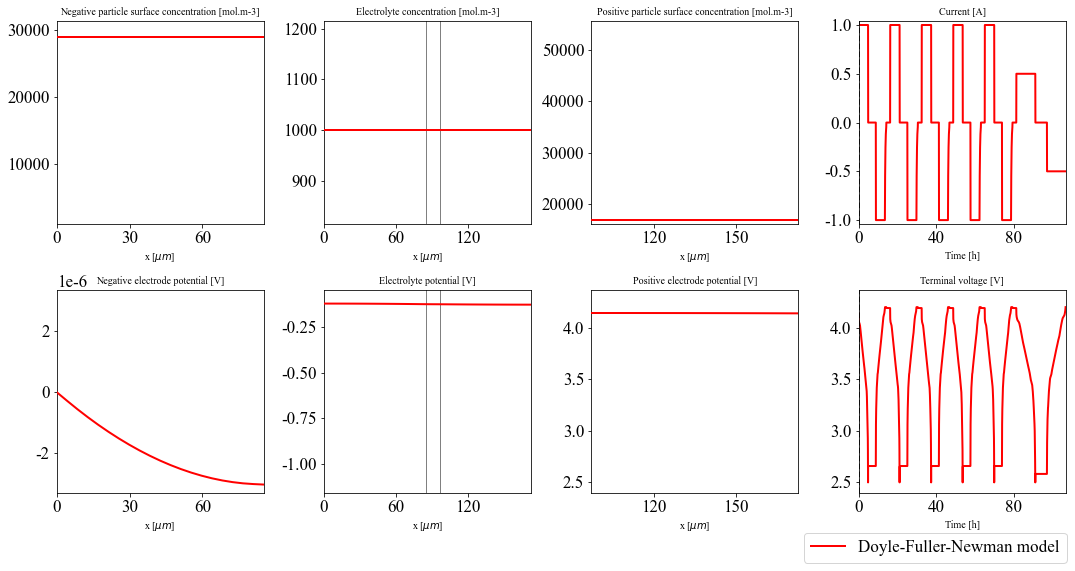

In [14]:
Sim_0.plot()

In [12]:
k=0
while k < SaveTimes_NonDry:     # run model - big loop, 1170 / 78 = 15,
    i=0
    while i < Small_Loop:
        Model_NonDry_i, Sol_NonDry_i  = Run_Model_Base_On_Last_Solution( Model_NonDry[-1]  , Sol_NonDry[-1] , 1 , Para_0 ,Experiment_Long ,Real_SaveAs_Cycles)
        Model_NonDry.append(Model_NonDry_i)    ; Sol_NonDry.append(Sol_NonDry_i)  ;
        #print(i)
        i += 1
    # run 1/10 C for 1 time
    Model_NonDry_i_RPT, Sol_NonDry_i_RPT  = Run_Model_Base_On_Last_Solution_RPT( Model_NonDry[-1]  , Sol_NonDry[-1] , 1 , Para_0 ,Experiment_RPT ,RPT_Cycles )
    Model_NonDry.append(Model_NonDry_i_RPT)    ; Sol_NonDry.append(Sol_NonDry_i_RPT)  ;  
    print("This is the ",k, "cycle")  
    k += 1
################ Post-processing # For non-dry model:##################################
T_0                  =  Para_0['Initial temperature [K]'];
cs_Neg_Max           =  Para_0["Maximum concentration in negative electrode [mol.m-3]"];
L_z                  =  Para_0["Electrode height [m]"]
L_y                  =  Para_0["Initial Electrode width [m]"] 
L_p                  =  Para_0["Positive electrode thickness [m]"]
L_n                  =  Para_0["Negative electrode thickness [m]"]
L_s                  =  Para_0["Separator thickness [m]"]
x_n = Sol_NonDry[0].cycles[0].steps[1]["x_n [m]"].entries[:,-1]; x = Sol_NonDry[0].cycles[0].steps[1]["x [m]"].entries[:,-1];
# CC end ageing cycle
Epsilon_Neg_CCend_NonDry_All = [];  Epsilon_SEI_Neg_CCend_NonDry_All=[];     Epsilon_CCend_NonDry_All = [];    Epsilon_ce_CCend_NonDry_All = [];  
jSEI_Neg_Int_CCend_NonDry_All = [];j_Neg_Int_CCend_NonDry_All = [];  j_Neg_CCend_NonDry_All = [];        # four current density
Eta_Elely_CCend_NonDry_All = [];  c_Li_Elely_CCend_NonDry_All = []; Eta_Neg_rec_CCend_NonDry_All =[];   
c_s_Neg_Surf_CCend_NonDry_All = [];  ElelyConduct_CCend_NonDry_All = []; ElelyDiff_CCend_NonDry_All = [];
Eff_ElelyConduct_CCend_NonDry_All = []; Eff_ElelyDiff_CCend_NonDry_All = [];
# CD end ageing cycle
Epsilon_Neg_CDend_NonDry_All = [];  Epsilon_SEI_Neg_CDend_NonDry_All=[];     Epsilon_CDend_NonDry_All = [];    Epsilon_ce_CDend_NonDry_All = [];  
jSEI_Neg_Int_CDend_NonDry_All = [];j_Neg_Int_CDend_NonDry_All = [];  j_Neg_CDend_NonDry_All = [];        # four current density
Eta_Elely_CDend_NonDry_All = [];  c_Li_Elely_CDend_NonDry_All = []; Eta_Neg_rec_CDend_NonDry_All =[];   
c_s_Neg_Surf_CDend_NonDry_All = [];  ElelyConduct_CDend_NonDry_All = []; ElelyDiff_CDend_NonDry_All = [];
Eff_ElelyConduct_CDend_NonDry_All = []; Eff_ElelyDiff_CDend_NonDry_All = [];                                                     #  Negative electrode reaction overpotential [V]   #  Electrolyte potential [V]

Time_RPT_CDend_NonDry_All = [];       Vol_RPT_CDend_NonDry_All = [];      # RPT should always be CD end
Tot_Li_JR_CCend_NonDry_All = [];   Tot_Li_Solid_CCend_NonDry_All = [];  Tot_LiLoss_Solid_CCend_NonDry_All = [];Tot_LiLoss_Elely_CCend_NonDry_All = [];Tot_Li_Elely_CCend_NonDry_All = [];   
# add first ageing cycle                                                                               
#     CC end ageing cycle
Epsilon_Neg_CCend_NonDry_All    .append( Sol_NonDry[1].cycles[0].steps[1]["Negative electrode porosity"].entries[:,-1] )
Epsilon_SEI_Neg_CCend_NonDry_All.append( (Sol_NonDry[1].cycles[0].steps[1]["Inner SEI concentration [mol.m-3]"].entries[:,-1]+Sol_NonDry[1].cycles[0].steps[1]["Outer SEI concentration [mol.m-3]"].entries[:,-1]) * Para_0["Outer SEI partial molar volume [m3.mol-1]"] )
Epsilon_CCend_NonDry_All        .append( Sol_NonDry[1].cycles[0].steps[1]["Porosity"].entries[:,-1] )
Epsilon_ce_CCend_NonDry_All     .append( Sol_NonDry[1].cycles[0].steps[1]["Porosity times concentration"].entries[:,-1] )
jSEI_Neg_Int_CCend_NonDry_All   .append(Sol_NonDry[1].cycles[0].steps[1]["SEI interfacial current density [A.m-2]"].entries[:,-1] )
j_Neg_Int_CCend_NonDry_All      .append(Sol_NonDry[1].cycles[0].steps[1]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
j_Neg_CCend_NonDry_All          .append(Sol_NonDry[1].cycles[0].steps[1]["Negative electrode current density [A.m-2]"].entries[:,-1] )
Eta_Elely_CCend_NonDry_All  .append(Sol_NonDry[1].cycles[0].steps[1]["Electrolyte potential [V]"].entries[:,-1] )
c_Li_Elely_CCend_NonDry_All     .append(Sol_NonDry[1].cycles[0].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
Eta_Neg_rec_CCend_NonDry_All    .append(Sol_NonDry[1].cycles[0].steps[1]["Negative electrode reaction overpotential [V]"].entries[:,-1] )   
c_s_Neg_Surf_CCend_NonDry_All   .append(Sol_NonDry[1].cycles[0].steps[1]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

ce_tem = Sol_NonDry[1].cycles[0].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
for i_ce_tem in range(0,np.size(ce_tem)):
    con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
    dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
ElelyConduct_CCend_NonDry_All   .append(con_ii);
ElelyDiff_CCend_NonDry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,

Eff_ElelyConduct_CCend_NonDry_All.append(  np.multiply( ElelyConduct_CCend_NonDry_All[-1], Epsilon_CCend_NonDry_All[-1]**1.5) )
Eff_ElelyDiff_CCend_NonDry_All   .append(  np.multiply( ElelyDiff_CCend_NonDry_All   [-1], Epsilon_CCend_NonDry_All[-1]**1.5) )
#      CD end ageing cycle
Epsilon_Neg_CDend_NonDry_All    .append( Sol_NonDry[1].cycles[0].steps[0]["Negative electrode porosity"].entries[:,-1] )
Epsilon_SEI_Neg_CDend_NonDry_All.append( (Sol_NonDry[1].cycles[0].steps[0]["Inner SEI concentration [mol.m-3]"].entries[:,-1]+Sol_NonDry[1].cycles[0].steps[0]["Outer SEI concentration [mol.m-3]"].entries[:,-1]) * Para_0["Outer SEI partial molar volume [m3.mol-1]"] )
Epsilon_CDend_NonDry_All        .append( Sol_NonDry[1].cycles[0].steps[0]["Porosity"].entries[:,-1] )
Epsilon_ce_CDend_NonDry_All     .append( Sol_NonDry[1].cycles[0].steps[0]["Porosity times concentration"].entries[:,-1] )
jSEI_Neg_Int_CDend_NonDry_All   .append(Sol_NonDry[1].cycles[0].steps[0]["SEI interfacial current density [A.m-2]"].entries[:,-1] )
j_Neg_Int_CDend_NonDry_All      .append(Sol_NonDry[1].cycles[0].steps[0]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
j_Neg_CDend_NonDry_All          .append(Sol_NonDry[1].cycles[0].steps[0]["Negative electrode current density [A.m-2]"].entries[:,-1] )
Eta_Elely_CDend_NonDry_All  .append(Sol_NonDry[1].cycles[0].steps[0]["Electrolyte potential [V]"].entries[:,-1] )
c_Li_Elely_CDend_NonDry_All     .append(Sol_NonDry[1].cycles[0].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
Eta_Neg_rec_CDend_NonDry_All    .append(Sol_NonDry[1].cycles[0].steps[0]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
c_s_Neg_Surf_CDend_NonDry_All   .append(Sol_NonDry[1].cycles[0].steps[0]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

ce_tem = Sol_NonDry[1].cycles[0].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
for i_ce_tem in range(0,np.size(ce_tem)):
    con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
    dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
ElelyConduct_CDend_NonDry_All   .append(con_ii);
ElelyDiff_CDend_NonDry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,

Eff_ElelyConduct_CDend_NonDry_All.append(  np.multiply( ElelyConduct_CDend_NonDry_All[-1], Epsilon_CDend_NonDry_All[-1]**1.5) )
Eff_ElelyDiff_CDend_NonDry_All   .append(  np.multiply( ElelyDiff_CDend_NonDry_All   [-1], Epsilon_CDend_NonDry_All[-1]**1.5) )

Tot_Li_Elely_CCend_NonDry_All   .append(Sol_NonDry[1].cycles[0].steps[1]["Total lithium in electrolyte [mol]"].entries[-1])
Tot_Li_JR_CCend_NonDry_All      .append(Sol_NonDry[1].cycles[0].steps[1]["Total lithium [mol]"].entries[-1])
Tot_Li_Solid_CCend_NonDry_All   .append(Sol_NonDry[1].cycles[0].steps[1]["Total lithium in particles [mol]"].entries[-1])
Tot_LiLoss_Solid_CCend_NonDry_All.append(Sol_NonDry[1].cycles[0].steps[1]["Total lithium lost from particles [mol]"].entries[-1])
Tot_LiLoss_Elely_CCend_NonDry_All.append(Sol_NonDry[1].cycles[0].steps[1]["Total lithium lost from electrolyte [mol]"].entries[-1])
for k in index_NonDry:
    #     CC end ageing cycle
    Epsilon_Neg_CCend_NonDry_All.append(Sol_NonDry[k].cycles[-1].steps[1]["Negative electrode porosity"].entries[:,-1] )
    Epsilon_SEI_Neg_CCend_NonDry_All.append((Sol_NonDry[k].cycles[-1].steps[1]["Inner SEI concentration [mol.m-3]"].entries[:,-1]+Sol_NonDry[k].cycles[-1].steps[1]["Outer SEI concentration [mol.m-3]"].entries[:,-1]) * Para_0["Outer SEI partial molar volume [m3.mol-1]"] )
    Epsilon_CCend_NonDry_All        .append( Sol_NonDry[k].cycles[-1].steps[1]["Porosity"].entries[:,-1] )
    Epsilon_ce_CCend_NonDry_All     .append( Sol_NonDry[k].cycles[-1].steps[1]["Porosity times concentration"].entries[:,-1] )
    jSEI_Neg_Int_CCend_NonDry_All   .append(Sol_NonDry[k].cycles[-1].steps[1]["SEI interfacial current density [A.m-2]"].entries[:,-1] )
    j_Neg_Int_CCend_NonDry_All      .append(Sol_NonDry[k].cycles[-1].steps[1]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
    j_Neg_CCend_NonDry_All          .append(Sol_NonDry[k].cycles[-1].steps[1]["Negative electrode current density [A.m-2]"].entries[:,-1] )
    Eta_Elely_CCend_NonDry_All  .append(Sol_NonDry[k].cycles[-1].steps[1]["Electrolyte potential [V]"].entries[:,-1] )
    c_Li_Elely_CCend_NonDry_All     .append(Sol_NonDry[k].cycles[-1].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
    Eta_Neg_rec_CCend_NonDry_All    .append(Sol_NonDry[k].cycles[-1].steps[1]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
    c_s_Neg_Surf_CCend_NonDry_All   .append(Sol_NonDry[k].cycles[-1].steps[1]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

    ce_tem = Sol_NonDry[k].cycles[-1].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
    for i_ce_tem in range(0,np.size(ce_tem)):
        con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
        dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
    ElelyConduct_CCend_NonDry_All   .append(con_ii);
    ElelyDiff_CCend_NonDry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,    

    Eff_ElelyConduct_CCend_NonDry_All.append(  np.multiply( ElelyConduct_CCend_NonDry_All[-1], Epsilon_CCend_NonDry_All[-1]**1.5) )
    Eff_ElelyDiff_CCend_NonDry_All   .append(  np.multiply( ElelyDiff_CCend_NonDry_All   [-1], Epsilon_CCend_NonDry_All[-1]**1.5) )
    #      CD end ageing cycle
    Epsilon_Neg_CDend_NonDry_All.append(Sol_NonDry[k].cycles[-1].steps[0]["Negative electrode porosity"].entries[:,-1] )
    Epsilon_SEI_Neg_CDend_NonDry_All.append((Sol_NonDry[k].cycles[-1].steps[0]["Inner SEI concentration [mol.m-3]"].entries[:,-1]+Sol_NonDry[k].cycles[-1].steps[0]["Outer SEI concentration [mol.m-3]"].entries[:,-1]) * Para_0["Outer SEI partial molar volume [m3.mol-1]"] )
    Epsilon_CDend_NonDry_All        .append( Sol_NonDry[k].cycles[-1].steps[0]["Porosity"].entries[:,-1] )
    Epsilon_ce_CDend_NonDry_All     .append( Sol_NonDry[k].cycles[-1].steps[0]["Porosity times concentration"].entries[:,-1] )
    jSEI_Neg_Int_CDend_NonDry_All   .append(Sol_NonDry[k].cycles[-1].steps[0]["SEI interfacial current density [A.m-2]"].entries[:,-1] )
    j_Neg_Int_CDend_NonDry_All      .append(Sol_NonDry[k].cycles[-1].steps[0]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
    j_Neg_CDend_NonDry_All          .append(Sol_NonDry[k].cycles[-1].steps[0]["Negative electrode current density [A.m-2]"].entries[:,-1] )
    Eta_Elely_CDend_NonDry_All  .append(Sol_NonDry[k].cycles[-1].steps[0]["Electrolyte potential [V]"].entries[:,-1] )
    c_Li_Elely_CDend_NonDry_All     .append(Sol_NonDry[k].cycles[-1].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
    Eta_Neg_rec_CDend_NonDry_All    .append(Sol_NonDry[k].cycles[-1].steps[0]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
    c_s_Neg_Surf_CDend_NonDry_All   .append(Sol_NonDry[k].cycles[-1].steps[0]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

    ce_tem = Sol_NonDry[k].cycles[-1].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
    for i_ce_tem in range(0,np.size(ce_tem)):
        con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
        dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
    ElelyConduct_CDend_NonDry_All   .append(con_ii);
    ElelyDiff_CDend_NonDry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii, 

    Eff_ElelyConduct_CDend_NonDry_All.append(  np.multiply( ElelyConduct_CDend_NonDry_All[-1], Epsilon_CDend_NonDry_All[-1]**1.5) )
    Eff_ElelyDiff_CDend_NonDry_All   .append(  np.multiply( ElelyDiff_CDend_NonDry_All   [-1], Epsilon_CDend_NonDry_All[-1]**1.5) )

    Tot_Li_Elely_CCend_NonDry_All   .append(Sol_NonDry[k].cycles[-1].steps[1]["Total lithium in electrolyte [mol]"].entries[-1])
    Tot_Li_JR_CCend_NonDry_All      .append(Sol_NonDry[k].cycles[-1].steps[1]["Total lithium [mol]"].entries[-1])
    Tot_Li_Solid_CCend_NonDry_All   .append(Sol_NonDry[k].cycles[-1].steps[1]["Total lithium in particles [mol]"].entries[-1])
    Tot_LiLoss_Solid_CCend_NonDry_All.append(Sol_NonDry[k].cycles[-1].steps[1]["Total lithium lost from particles [mol]"].entries[-1])
    Tot_LiLoss_Elely_CCend_NonDry_All.append(Sol_NonDry[k].cycles[-1].steps[1]["Total lithium lost from electrolyte [mol]"].entries[-1])
for m in index2_NonDry:
    Time_RPT_CDend_NonDry_All.append(Sol_NonDry[m].cycles[-1].steps[0]["Time [h]"].entries-Sol_NonDry[m].cycles[-1].steps[0]["Time [h]"].entries[0]) ;   
    Vol_RPT_CDend_NonDry_All.append (Sol_NonDry[m].cycles[-1].steps[0]["Terminal voltage [V]"].entries)  ;
Vol_RPT_CDend_NonDry_All[0] = Sol_NonDry[0].cycles[-1].steps[25]["Terminal voltage [V]"].entries;                   ######## Note the first cycle is different, should choose 
Time_RPT_CDend_NonDry_All[0]= Sol_NonDry[0].cycles[-1].steps[25]["Time [h]"].entries-Sol_NonDry[0].cycles[-1].steps[25]["Time [h]"].entries[0] ;  

Cap_RPT_NonDry_All=[];   CapLoss_SEI_NonDry_All = [];  R_Local_ECM_NonDry_All =[];  R_Neg_X_avg_NonDry_All =[]; Charge_ThroughPut_NonDry_All =[];
LAM_Neg_NonDry_All =[];  Cap_Pos_NonDry_All =[];       Cap_Neg_NonDry_All =[];      Vol_Pore_JR_NonDry_All =[]; X_avg_c_Li_NonDry_All =[];
for k in index2_NonDry:
    Cap_RPT_NonDry_All.append    (Sol_NonDry[k].cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[-1] - Sol_NonDry[k].cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[0])
    CapLoss_SEI_NonDry_All.append(Sol_NonDry[k].cycles[-1].steps[0]["Loss of capacity to SEI [A.h]"].entries[-1])
    Cap_Pos_NonDry_All.append    (Sol_NonDry[k].cycles[-1].steps[0]["Positive electrode capacity [A.h]"].entries[-1])
    Cap_Neg_NonDry_All.append    (Sol_NonDry[k].cycles[-1].steps[0]["Negative electrode capacity [A.h]"].entries[-1])      
    R_Local_ECM_NonDry_All.append(Sol_NonDry[k].cycles[-1].steps[0]["Local ECM resistance [Ohm]"].entries[-1])
    X_avg_c_Li_NonDry_All. append(Sol_NonDry[k].cycles[-1].steps[0]["X-averaged electrolyte concentration [mol.m-3]"].entries[-1])
    R_Neg_X_avg_NonDry_All.append(Sol_NonDry[k].cycles[-1].steps[0]["X-averaged negative electrode resistance [Ohm.m2]"].entries[-1])
    PoreVolNeg = Sol_NonDry[k].cycles[-1].steps[0]["X-averaged negative electrode porosity"].entries[-1]*L_n*L_y*L_z*1e6;
    PoreVolSep = Sol_NonDry[k].cycles[-1].steps[0]["X-averaged separator porosity"].entries[-1]*L_s*L_y*L_z*1e6;
    PoreVolPos = Sol_NonDry[k].cycles[-1].steps[0]["X-averaged positive electrode porosity"].entries[-1]*L_p*L_y*L_z*1e6;
    Vol_Pore_JR_NonDry_All.append(PoreVolNeg + PoreVolSep + PoreVolPos )
############################## Capacity throughput
Charge_ThroughPut_i = [];
for i in range(0,np.size(index2_NonDry)-1):
    cap_i = 0; 
    for Sol_NonDry_i in Sol_NonDry[index2_NonDry[i]+1:index2_NonDry[i+1]+1]:
        for cycle in Sol_NonDry_i.cycles:
            for step in cycle.steps:
                cap_i += abs(step["Discharge capacity [A.h]"].entries[-1] - step["Discharge capacity [A.h]"].entries[0])
    Charge_ThroughPut_i.append(cap_i) ; #print(cap_i);
Charge_ThroughPut = [];   
for i in range(0,np.size(Charge_ThroughPut_i)+1):
    sum = 0
    for cap_i in Charge_ThroughPut_i[:i]:
        sum += cap_i;
    Charge_ThroughPut.append(sum)
Charge_ThroughPut_NonDry_All.append(Charge_ThroughPut) 

# SOC at start of discharge  
NegSoc_S_Dis_NonDry_All=[];    NegSoc_E_Dis_NonDry_All=[];   PosSoc_S_Dis_NonDry_All=[];    PosSoc_E_Dis_NonDry_All=[];   # S means start ; E means end
for k in index_NonDry:  
    NegSoc_S_Dis=[];       NegSoc_E_Dis=[];   PosSoc_S_Dis=[];    PosSoc_E_Dis=[];
    NegSoc_S_Dis.append    (Sol_NonDry[k].cycles[0].steps[0]["Negative electrode SOC"].entries[0] )
    NegSoc_E_Dis.append    (Sol_NonDry[k].cycles[0].steps[0]["Negative electrode SOC"].entries[-1] )
    PosSoc_S_Dis.append    (Sol_NonDry[k].cycles[0].steps[0]["Positive electrode SOC"].entries[0] )
    PosSoc_E_Dis.append    (Sol_NonDry[k].cycles[0].steps[0]["Positive electrode SOC"].entries[-1] )
    NegSoc_S_Dis_NonDry_All.append(NegSoc_S_Dis);    NegSoc_E_Dis_NonDry_All.append(NegSoc_E_Dis);  
    PosSoc_S_Dis_NonDry_All.append(PosSoc_S_Dis);    PosSoc_E_Dis_NonDry_All.append(PosSoc_E_Dis);   

del Sol_NonDry; #  

KeyError: "'Negative electrode porosity times concentration' not found. Best matches are ['Negative electrolyte concentration', 'Negative electrode dead lithium concentration', 'Negative electrode lithium plating concentration']"

In [ ]:
# Run model with electrolyte dry out
Ratio_excess = [1.0, 1.06, 1.09];   
for mm in range(0,1):
    QLossSEI_C_3_Dry_All =[];    Cap_Dis_C_3_All=[];
    Vol_Elely_Tot_All_All  = [];       Vol_Elely_JR_All_All =[];         Vol_Pore_tot_All_All =[];
    Ratio_CeEC_All_All     = [];       Ratio_CeLi_All_All = [];          Ratio_Dryout_All_All =[];
    Vol_EC_consumed_All_All= [];       Vol_Elely_need_All_All = [];      Width_all_All        =[];
    Vol_Elely_add_All_All  = [];       Vol_Pore_decrease_All_All =[];    Index_update_all_all =[]; 
    # CC end ageing cycle
    Epsilon_Neg_CCend_Dry_All_All = [];  Epsilon_SEI_Neg_CCend_Dry_All_All=[];     Epsilon_CCend_Dry_All_All = [];    Epsilon_ce_CCend_Dry_All_All = [];  
    jSEI_Neg_Int_CCend_Dry_All_All = []; j_Neg_Int_CCend_Dry_All_All = [];         j_Neg_CCend_Dry_All_All = [];        # four current density
    Eta_Elely_CCend_Dry_All_All = [];  c_Li_Elely_CCend_Dry_All_All = []; Eta_Neg_rec_CCend_Dry_All_All =[];   
    c_s_Neg_Surf_CCend_Dry_All_All = [];  ElelyConduct_CCend_Dry_All_All = []; ElelyDiff_CCend_Dry_All_All = [];
    Eff_ElelyConduct_CCend_Dry_All_All = []; Eff_ElelyDiff_CCend_Dry_All_All = [];
    # CD end ageing cycle
    Epsilon_Neg_CDend_Dry_All_All = [];  Epsilon_SEI_Neg_CDend_Dry_All_All=[];     Epsilon_CDend_Dry_All_All = [];    Epsilon_ce_CDend_Dry_All_All = [];  
    jSEI_Neg_Int_CDend_Dry_All_All = []; j_Neg_Int_CDend_Dry_All_All = [];         j_Neg_CDend_Dry_All_All = [];        # four current density
    Eta_Elely_CDend_Dry_All_All = [];  c_Li_Elely_CDend_Dry_All_All = []; Eta_Neg_rec_CDend_Dry_All_All =[];   
    c_s_Neg_Surf_CDend_Dry_All_All = [];  ElelyConduct_CDend_Dry_All_All = []; ElelyDiff_CDend_Dry_All_All = [];
    Eff_ElelyConduct_CDend_Dry_All_All = []; Eff_ElelyDiff_CDend_Dry_All_All = [];

    Time_RPT_CDend_Dry_All_All = [];       Vol_RPT_CDend_Dry_All_All = [];    #
    Tot_LiLoss_Solid_CCend_Dry_All_All = [];Tot_LiLoss_Elely_CCend_Dry_All_All = [];    Tot_Li_Elely_CCend_Dry_All_All = [];            Tot_Li_JR_CCend_Dry_All_All = [];   Tot_Li_Solid_CCend_Dry_All_All = [];  
    Cap_RPT_Dry_All_All=[];      CapLoss_SEI_Dry_All_All = []; Cap_Neg_Dry_All_All =[]; Cap_Pos_Dry_All_All = []; R_Local_ECM_Dry_All_All =[];  R_Neg_X_avg_Dry_All_All =[];
    X_avg_c_Li_Dry_All_All=[];   Charge_ThroughPut_Dry_All_All =[];
    NegSoc_S_Dis_Dry_All_All=[]; NegSoc_E_Dis_Dry_All_All = [];  PosSoc_S_Dis_Dry_All_All = []; PosSoc_E_Dis_Dry_All_All =[]; 

Model_0  = pb.lithium_ion.DFN(options={"SEI": "solvent-diffusion limited","SEI film resistance": "distributed","SEI porosity change": "true" }) #
Num_Scan = np.size(Ratio_excess);    Ratio_excess_succeed =[];
for Ratio_excess_i in Ratio_excess:
   #  try: 
    ChemistryChen=pb.parameter_sets.Chen2020   # Ren2018  Chen2020_plating
    Para_0=pb.ParameterValues(chemistry=ChemistryChen)
    Para_0.update({'SEI resistivity [Ohm.m]':R_SEI}) ;
    Para_0.update({'Outer SEI solvent diffusivity [m2.s-1]':Diff_SEI});
    Para_0.update({'Bulk solvent concentration [mol.m-3]':Bulk_Sol_Con});
    Para_0.update({'Initial concentration in negative electrode [mol.m-3]':cs_Neg_Init })
    Para_0.update({'Initial electrolyte excessive amount ratio':Ratio_excess_i})   # 
    ModelTimer = pb.Timer()
    Sim_0    = pb.Simulation(Model_0, experiment = Experiment_Breakin,parameter_values = Para_0,solver = pb.CasadiSolver(),) #mode="safe"
    Sol_0    = Sim_0.solve()
    #Step2: Initialize
    Vol_Elely_Tot_All  = [];       Vol_Elely_JR_All =[];         Vol_Pore_tot_All =[];
    Ratio_CeEC_All     = [];       Ratio_CeLi_All = [];          Ratio_Dryout_All =[];
    Vol_EC_consumed_All= [];       Vol_Elely_need_All = [];      Width_all        =[];
    Vol_Elely_add_All  = [];       Vol_Pore_decrease_All =[];
    Para_All           = [];       Model_All = [];               Sol_All_i =[]  ;       
    CeEC_0               =  Para_0['Bulk solvent concentration [mol.m-3]'];     CeEC  =  CeEC_0;
    CeLi_0               =  Para_0['Initial concentration in electrolyte [mol.m-3]'];        CeLi  =  CeLi_0;
    T_0                  =  Para_0['Initial temperature [K]']
    Porosity_Neg_0       =  Para_0['Negative electrode porosity']  
    Porosity_Pos_0       =  Para_0['Positive electrode porosity']  
    Porosity_Sep_0       =  Para_0['Separator porosity']  
    cs_Neg_Max           =  Para_0["Maximum concentration in negative electrode [mol.m-3]"];
    L_p                  =  Para_0["Positive electrode thickness [m]"]
    L_n                  =  Para_0["Negative electrode thickness [m]"]
    L_s                  =  Para_0["Separator thickness [m]"]
    L_y_0                =  Para_0["Initial Electrode width [m]"]
    L_z_0                =  Para_0["Initial Electrode height [m]"]
    Int_ElelyExces_Ratio =  Para_0["Initial electrolyte excessive amount ratio"] 
    x_n = Sol_0.cycles[0].steps[0]["x_n [m]"].entries[:,-1]; x = Sol_0.cycles[0].steps[0]["x [m]"].entries[:,-1];
    Vol_Elely_Tot        =  ( L_n*Porosity_Neg_0 +  L_p*Porosity_Pos_0  +  L_s*Porosity_Sep_0  )  * L_y_0 * L_z_0 * Int_ElelyExces_Ratio # Set initial electrolyte amount [L] 
    Vol_Elely_JR         =  ( L_n*Porosity_Neg_0 +  L_p*Porosity_Pos_0  +  L_s*Porosity_Sep_0  )  * L_y_0 * L_z_0
    Vol_Pore_tot         =  ( L_n*Porosity_Neg_0 +  L_p*Porosity_Pos_0  +  L_s*Porosity_Sep_0  )  * L_y_0 * L_z_0
    Ratio_CeEC           =  1.0   
    Ratio_CeLi           =  1.0   
    Ratio_Dryout         =  1.0
    Vol_EC_consumed      =  0
    Vol_Elely_need       =  0
    Vol_Elely_add        =  0
    Vol_Pore_decrease    =  0
    print('Initial electrolyte amount is ', Vol_Elely_Tot*1e6, 'mL') 
    Para_0.update({'Current total electrolyte volume in jelly roll [m3]':Vol_Elely_JR})
    Para_0.update({'Current total electrolyte volume in whole cell [m3]':Vol_Elely_Tot})   
    Vol_Elely_Tot_All.append(Vol_Elely_Tot*1e6);            Vol_Elely_JR_All.append(Vol_Elely_JR*1e6);     Vol_Pore_tot_All.append(Vol_Pore_tot*1e6);           
    Ratio_CeEC_All.append(Ratio_CeEC);                      Ratio_CeLi_All.append(Ratio_CeLi);             Ratio_Dryout_All.append(Ratio_Dryout);
    Vol_EC_consumed_All.append(Vol_EC_consumed*1e6);        Vol_Elely_need_All.append(Vol_Elely_need*1e6);     Width_all.append(L_y_0);
    Vol_Elely_add_All.append(Vol_Elely_add*1e6);            Vol_Pore_decrease_All.append(Vol_Pore_decrease*1e6);
    Para_All.append(Para_0);                                Model_All.append(Model_0);    Sol_All_i.append(Sol_0); 
    #Step3: Write a big loop to finish the long experiment,    
    Index_update_all     =[]; cycle_count =0; Index_update_all.append(cycle_count);
    k=0; 
    while k < SaveTimes:    # biggest loop, repeat 240 cycles + RPT, for 13 times, making 3120 cycles in total
        i=0
        while i < Small_Loop:
            # run ageing cycles, and update parameters (have another version not update)
            Data_Pack   = Cal_new_con_for_Li_EC (  Sol_All_i[-1],   Para_All[-1],   CeEC_0,   CeLi_0   )
            [Vol_EC_consumed, Vol_Elely_need, Test_V, Vol_Elely_add, Vol_Elely_Tot_new, Vol_Elely_JR_new, Vol_Pore_tot_new, Vol_Pore_decrease, Ratio_Dryout, Ratio_CeEC, Ratio_CeLi, Width_new, ] = Data_Pack;
            # Append single object to All object     
            Vol_Elely_Tot_All.append(Vol_Elely_Tot_new*1e6);    Vol_Elely_JR_All.append(Vol_Elely_JR_new*1e6);     Vol_Pore_tot_All.append(Vol_Pore_tot_new*1e6);           
            Ratio_CeEC_All.append(Ratio_CeEC);                  Ratio_CeLi_All.append(Ratio_CeLi);                 Ratio_Dryout_All.append(Ratio_Dryout);
            Vol_EC_consumed_All.append(Vol_EC_consumed*1e6);    Vol_Elely_need_All.append(Vol_Elely_need*1e6);     Width_all.append(Width_new);
            Vol_Elely_add_All.append(Vol_Elely_add*1e6);        Vol_Pore_decrease_All.append(Vol_Pore_decrease*1e6);
            # 2nd: update EC and Li concentration, Ratio_Dryout
            Paraupdate  = Update_param ( Para_All[-1],  Ratio_CeEC_All[-1], Ratio_Dryout_All[-1], Vol_Elely_Tot_All[-1]/1e6, Vol_Elely_JR_All[-1]/1e6,  )
            Para_All.append(Paraupdate)    
            # 3rd: run model based on new parameter and last updated solution Model  , Sol, Ratio_CeLi, Para_update, ModelExperiment, Update_Cycles
            ModelModel_new, ModelSolnew  = Run_Model_Base_On_Last_Solution( Model_All[-1]  , Sol_All_i[-1] , Ratio_CeLi_All[-1], Para_All[-1] ,Experiment_Long, Real_SaveAs_Cycles )
            Model_All.append(ModelModel_new)  ; 
            Sol_All_i.append(ModelSolnew)    ; 
            i += 1;  cycle_count +=  Update_Cycles; Index_update_all.append(cycle_count);
        # run RPT for 3 times, and also update parameters (otherwise will have problems)
        Data_Pack   = Cal_new_con_for_Li_EC (  Sol_All_i[-1],   Para_All[-1],   CeEC_0,   CeLi_0   )
        [Vol_EC_consumed, Vol_Elely_need, Test_V, Vol_Elely_add, Vol_Elely_Tot_new, Vol_Elely_JR_new, Vol_Pore_tot_new, Vol_Pore_decrease, Ratio_Dryout, Ratio_CeEC, Ratio_CeLi, Width_new, ] = Data_Pack;
        # Append single object to All object     
        Vol_Elely_Tot_All.append(Vol_Elely_Tot_new*1e6);    Vol_Elely_JR_All.append(Vol_Elely_JR_new*1e6);     Vol_Pore_tot_All.append(Vol_Pore_tot_new*1e6);           
        Ratio_CeEC_All.append(Ratio_CeEC);                  Ratio_CeLi_All.append(Ratio_CeLi);                 Ratio_Dryout_All.append(Ratio_Dryout);
        Vol_EC_consumed_All.append(Vol_EC_consumed*1e6);    Vol_Elely_need_All.append(Vol_Elely_need*1e6);     Width_all.append(Width_new);
        Vol_Elely_add_All.append(Vol_Elely_add*1e6);        Vol_Pore_decrease_All.append(Vol_Pore_decrease*1e6); 
        Index_update_all.append(cycle_count);
        # 2nd: update EC and Li concentration, Ratio_Dryout
        Paraupdate  = Update_param (  Para_All[-1], Ratio_CeEC_All[-1], Ratio_Dryout_All[-1], Vol_Elely_Tot_All[-1]/1e6, Vol_Elely_JR_All[-1]/1e6,  )
        Para_All.append(Paraupdate)  
        Model_new_RPT, Sol_new_RPT  = Run_Model_Base_On_Last_Solution_RPT( Model_All[-1]  , Sol_All_i[-1] , Ratio_CeLi_All[-1],  Para_All[-1] ,Experiment_RPT, RPT_Cycles  )
        Model_All.append(Model_new_RPT)   ; Sol_All_i.append(Sol_new_RPT)     ;  
        k += 1
    Vol_Elely_Tot_All_All.append(Vol_Elely_Tot_All) ;      Vol_Elely_JR_All_All.append(Vol_Elely_JR_All);          Vol_Pore_tot_All_All.append(Vol_Pore_tot_All);
    Ratio_CeEC_All_All.append(Ratio_CeEC_All);             Ratio_CeLi_All_All.append(Ratio_CeLi_All);              Ratio_Dryout_All_All.append(Ratio_Dryout_All);
    Vol_EC_consumed_All_All.append(Vol_EC_consumed_All);   Vol_Elely_need_All_All.append(Vol_Elely_need_All);      Width_all_All.append(Width_all);
    Vol_Elely_add_All_All.append(Vol_Elely_add_All);       Vol_Pore_decrease_All_All.append(Vol_Pore_decrease_All);
    Index_update_all_all.append(Index_update_all);
    print("Solved this model in {}".format(ModelTimer.time()))
    """   except:
    SpeciPath = f'Fail/electrolyte excessive= {Ratio_excess_i}';
    WholePath = BasicPath + SpeciPath
    #os.mkdir( WholePath )
    #os.chdir(WholePath)
    print("Fail for some reasons \n\n")
    else: 
    print('I do it! \n\n')"""
    Ratio_excess_succeed.append(Ratio_excess_i);
    ######################         Post-processing         ####################################################################
    # CC end ageing cycle
    Epsilon_Neg_CCend_Dry_All = [];        Epsilon_SEI_Neg_CCend_Dry_All=[];    Epsilon_CCend_Dry_All = [];        Epsilon_ce_CCend_Dry_All = []; 
    jSEI_Neg_Int_CCend_Dry_All = [];       j_Neg_Int_CCend_Dry_All = [];        j_Neg_CCend_Dry_All = [];          
    Eta_Elely_CCend_Dry_All = [];      c_Li_Elely_CCend_Dry_All = [];       Eta_Neg_rec_CCend_Dry_All =[];   
    c_s_Neg_Surf_CCend_Dry_All = [];       ElelyConduct_CCend_Dry_All = [];     ElelyDiff_CCend_Dry_All = [];   
    Eff_ElelyConduct_CCend_Dry_All = [];   Eff_ElelyDiff_CCend_Dry_All = [];
    # CD end ageing cycle
    Epsilon_Neg_CDend_Dry_All = [];        Epsilon_SEI_Neg_CDend_Dry_All=[];    Epsilon_CDend_Dry_All = [];        Epsilon_ce_CDend_Dry_All = []; 
    jSEI_Neg_Int_CDend_Dry_All = [];       j_Neg_Int_CDend_Dry_All = [];        j_Neg_CDend_Dry_All = [];          
    Eta_Elely_CDend_Dry_All = [];      c_Li_Elely_CDend_Dry_All = [];       Eta_Neg_rec_CDend_Dry_All =[];   
    c_s_Neg_Surf_CDend_Dry_All = [];       ElelyConduct_CDend_Dry_All = [];     ElelyDiff_CDend_Dry_All = [];   
    Eff_ElelyConduct_CDend_Dry_All = [];   Eff_ElelyDiff_CDend_Dry_All = [];

    Tot_Li_Elely_CCend_Dry_All = [];      Tot_Li_JR_CCend_Dry_All = [];   Tot_Li_Solid_CCend_Dry_All = [];   Tot_LiLoss_Solid_CCend_Dry_All = [];Tot_LiLoss_Elely_CCend_Dry_All = [];
    Time_RPT_CDend_Dry_All = [];       Vol_RPT_CDend_Dry_All = [];       
    # add first ageing cycle
    Epsilon_Neg_CCend_Dry_All         .append(Sol_All_i[1].cycles[0].steps[1]["Negative electrode porosity"].entries[:,-1] )
    Epsilon_SEI_Neg_CCend_Dry_All     .append((Sol_All_i[1].cycles[0].steps[1]["Inner SEI concentration [mol.m-3]"].entries[:,-1]+Sol_All_i[1].cycles[0].steps[1]["Outer SEI concentration [mol.m-3]"].entries[:,-1] ) * Para_0["Outer SEI partial molar volume [m3.mol-1]"] )
    Epsilon_CCend_Dry_All             .append(Sol_All_i[1].cycles[0].steps[1]["Porosity"].entries[:,-1] )
    Epsilon_ce_CCend_Dry_All          .append(Sol_All_i[1].cycles[0].steps[1]["Porosity times concentration"].entries[:,-1] )
    jSEI_Neg_Int_CCend_Dry_All        .append(Sol_All_i[1].cycles[0].steps[1]["SEI interfacial current density [A.m-2]"].entries[:,-1] )
    j_Neg_Int_CCend_Dry_All           .append(Sol_All_i[1].cycles[0].steps[1]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
    j_Neg_CCend_Dry_All               .append(Sol_All_i[1].cycles[0].steps[1]["Negative electrode current density [A.m-2]"].entries[:,-1] )
    Eta_Elely_CCend_Dry_All       .append(Sol_All_i[1].cycles[0].steps[1]["Electrolyte potential [V]"].entries[:,-1] )
    c_Li_Elely_CCend_Dry_All          .append(Sol_All_i[1].cycles[0].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
    Eta_Neg_rec_CCend_Dry_All         .append(Sol_All_i[1].cycles[0].steps[1]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
    c_s_Neg_Surf_CCend_Dry_All        .append(Sol_All_i[1].cycles[0].steps[1]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

    ce_tem = Sol_All_i[1].cycles[0].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
    for i_ce_tem in range(0,np.size(ce_tem)):
        con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
        dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
    ElelyConduct_CCend_Dry_All   .append(con_ii);
    ElelyDiff_CCend_Dry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,

    Eff_ElelyConduct_CCend_Dry_All.append(  np.multiply( ElelyConduct_CCend_Dry_All[-1], Epsilon_CCend_Dry_All[-1]**1.5) )
    Eff_ElelyDiff_CCend_Dry_All   .append(  np.multiply( ElelyDiff_CCend_Dry_All   [-1], Epsilon_CCend_Dry_All[-1]**1.5) )
    # add first ageing cycle
    Epsilon_Neg_CDend_Dry_All         .append(Sol_All_i[1].cycles[0].steps[0]["Negative electrode porosity"].entries[:,-1] )
    Epsilon_SEI_Neg_CDend_Dry_All     .append((Sol_All_i[1].cycles[0].steps[0]["Inner SEI concentration [mol.m-3]"].entries[:,-1]+Sol_All_i[1].cycles[0].steps[0]["Outer SEI concentration [mol.m-3]"].entries[:,-1] ) * Para_0["Outer SEI partial molar volume [m3.mol-1]"] )
    Epsilon_CDend_Dry_All             .append(Sol_All_i[1].cycles[0].steps[0]["Porosity"].entries[:,-1] )
    Epsilon_ce_CDend_Dry_All          .append(Sol_All_i[1].cycles[0].steps[0]["Porosity times concentration"].entries[:,-1] )
    jSEI_Neg_Int_CDend_Dry_All        .append(Sol_All_i[1].cycles[0].steps[0]["SEI interfacial current density [A.m-2]"].entries[:,-1] )
    j_Neg_Int_CDend_Dry_All           .append(Sol_All_i[1].cycles[0].steps[0]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
    j_Neg_CDend_Dry_All               .append(Sol_All_i[1].cycles[0].steps[0]["Negative electrode current density [A.m-2]"].entries[:,-1] )
    Eta_Elely_CDend_Dry_All       .append(Sol_All_i[1].cycles[0].steps[0]["Electrolyte potential [V]"].entries[:,-1] )
    c_Li_Elely_CDend_Dry_All          .append(Sol_All_i[1].cycles[0].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
    Eta_Neg_rec_CDend_Dry_All         .append(Sol_All_i[1].cycles[0].steps[0]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
    c_s_Neg_Surf_CDend_Dry_All        .append(Sol_All_i[1].cycles[0].steps[0]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

    ce_tem = Sol_All_i[1].cycles[0].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
    for i_ce_tem in range(0,np.size(ce_tem)):
        con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
        dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
    ElelyConduct_CDend_Dry_All   .append(con_ii);
    ElelyDiff_CDend_Dry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,

    Eff_ElelyConduct_CDend_Dry_All.append(  np.multiply( ElelyConduct_CDend_Dry_All[-1], Epsilon_CDend_Dry_All[-1]**1.5) )
    Eff_ElelyDiff_CDend_Dry_All   .append(  np.multiply( ElelyDiff_CDend_Dry_All   [-1], Epsilon_CDend_Dry_All[-1]**1.5) )

    Tot_Li_Elely_CCend_Dry_All        .append(Sol_All_i[1].cycles[0].steps[1]["Total lithium in electrolyte [mol]"].entries[-1] )
    Tot_Li_JR_CCend_Dry_All      .append(Sol_All_i[1].cycles[0].steps[1]["Total lithium [mol]"].entries[-1])
    Tot_Li_Solid_CCend_Dry_All   .append(Sol_All_i[1].cycles[0].steps[1]["Total lithium in particles [mol]"].entries[-1])
    Tot_LiLoss_Solid_CCend_Dry_All.append(Sol_All_i[1].cycles[0].steps[1]["Total lithium lost from particles [mol]"].entries[-1])
    Tot_LiLoss_Elely_CCend_Dry_All.append(Sol_All_i[1].cycles[0].steps[1]["Total lithium lost from electrolyte [mol]"].entries[-1])
    for k in index:
        # CC end ageing cycle
        Epsilon_Neg_CCend_Dry_All     .append(Sol_All_i[k].cycles[-1].steps[1]["Negative electrode porosity"].entries[:,-1] )
        Epsilon_SEI_Neg_CCend_Dry_All .append((Sol_All_i[k].cycles[-1].steps[1]["Inner SEI concentration [mol.m-3]"].entries[:,-1] + Sol_All_i[k].cycles[-1].steps[1]["Outer SEI concentration [mol.m-3]"].entries[:,-1])* Para_0["Outer SEI partial molar volume [m3.mol-1]"] )
        Epsilon_CCend_Dry_All         .append(Sol_All_i[k].cycles[0].steps[1]["Porosity"].entries[:,-1] )
        Epsilon_ce_CCend_Dry_All      .append(Sol_All_i[k].cycles[0].steps[1]["Porosity times concentration"].entries[:,-1] )
        jSEI_Neg_Int_CCend_Dry_All    .append(Sol_All_i[k].cycles[-1].steps[1]["SEI interfacial current density [A.m-2]"].entries[:,-1] )
        j_Neg_Int_CCend_Dry_All       .append(Sol_All_i[k].cycles[-1].steps[1]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
        j_Neg_CCend_Dry_All           .append(Sol_All_i[k].cycles[-1].steps[1]["Negative electrode current density [A.m-2]"].entries[:,-1] )
        Eta_Elely_CCend_Dry_All   .append(Sol_All_i[k].cycles[-1].steps[1]["Electrolyte potential [V]"].entries[:,-1] )
        c_Li_Elely_CCend_Dry_All      .append(Sol_All_i[k].cycles[-1].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
        Eta_Neg_rec_CCend_Dry_All     .append(Sol_All_i[k].cycles[-1].steps[1]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
        c_s_Neg_Surf_CCend_Dry_All    .append(Sol_All_i[k].cycles[-1].steps[1]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

        ce_tem = Sol_All_i[k].cycles[-1].steps[1]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
        for i_ce_tem in range(0,np.size(ce_tem)):
            con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
            dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
        ElelyConduct_CCend_Dry_All   .append(con_ii);
        ElelyDiff_CCend_Dry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,

        Eff_ElelyConduct_CCend_Dry_All.append(  np.multiply( ElelyConduct_CCend_Dry_All[-1], Epsilon_CCend_Dry_All[-1]**1.5) )
        Eff_ElelyDiff_CCend_Dry_All   .append(  np.multiply( ElelyDiff_CCend_Dry_All   [-1], Epsilon_CCend_Dry_All[-1]**1.5) )
        # CD end ageing cycle
        Epsilon_Neg_CDend_Dry_All     .append(Sol_All_i[k].cycles[-1].steps[0]["Negative electrode porosity"].entries[:,-1] )
        Epsilon_SEI_Neg_CDend_Dry_All .append((Sol_All_i[k].cycles[-1].steps[0]["Inner SEI concentration [mol.m-3]"].entries[:,-1] + Sol_All_i[k].cycles[-1].steps[0]["Outer SEI concentration [mol.m-3]"].entries[:,-1])* Para_0["Outer SEI partial molar volume [m3.mol-1]"] )
        Epsilon_CDend_Dry_All         .append(Sol_All_i[k].cycles[0].steps[0]["Porosity"].entries[:,-1] )
        Epsilon_ce_CDend_Dry_All      .append(Sol_All_i[k].cycles[0].steps[0]["Porosity times concentration"].entries[:,-1] )
        jSEI_Neg_Int_CDend_Dry_All    .append(Sol_All_i[k].cycles[-1].steps[0]["SEI interfacial current density [A.m-2]"].entries[:,-1] )
        j_Neg_Int_CDend_Dry_All       .append(Sol_All_i[k].cycles[-1].steps[0]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] )
        j_Neg_CDend_Dry_All           .append(Sol_All_i[k].cycles[-1].steps[0]["Negative electrode current density [A.m-2]"].entries[:,-1] )
        Eta_Elely_CDend_Dry_All   .append(Sol_All_i[k].cycles[-1].steps[0]["Electrolyte potential [V]"].entries[:,-1] )
        c_Li_Elely_CDend_Dry_All      .append(Sol_All_i[k].cycles[-1].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1] )
        Eta_Neg_rec_CDend_Dry_All     .append(Sol_All_i[k].cycles[-1].steps[0]["Negative electrode reaction overpotential [V]"].entries[:,-1] )
        c_s_Neg_Surf_CDend_Dry_All    .append(Sol_All_i[k].cycles[-1].steps[0]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] )

        ce_tem = Sol_All_i[k].cycles[-1].steps[0]["Electrolyte concentration [mol.m-3]"].entries[:,-1]; con_ii = np.full(ce_tem.shape,0.0);   dif_ii = np.full(ce_tem.shape,0.0); 
        for i_ce_tem in range(0,np.size(ce_tem)):
            con_ii[i_ce_tem] = electrolyte_conductivity_Nyman2008(ce_tem[i_ce_tem], T_0) ;
            dif_ii[i_ce_tem] = electrolyte_diffusivity_Nyman2008 (ce_tem[i_ce_tem], T_0) ;
        ElelyConduct_CDend_Dry_All   .append(con_ii);
        ElelyDiff_CDend_Dry_All      .append(dif_ii);  del ce_tem,con_ii,dif_ii,

        Eff_ElelyConduct_CDend_Dry_All.append(  np.multiply( ElelyConduct_CDend_Dry_All[-1], Epsilon_CDend_Dry_All[-1]**1.5) )
        Eff_ElelyDiff_CDend_Dry_All   .append(  np.multiply( ElelyDiff_CDend_Dry_All   [-1], Epsilon_CDend_Dry_All[-1]**1.5) )
        
        Tot_Li_Elely_CCend_Dry_All    .append(Sol_All_i[k].cycles[-1].steps[1]["Total lithium in electrolyte [mol]"].entries[-1] )
        Tot_Li_JR_CCend_Dry_All      .append(Sol_All_i[k].cycles[-1].steps[1]["Total lithium [mol]"].entries[-1])
        Tot_Li_Solid_CCend_Dry_All   .append(Sol_All_i[k].cycles[-1].steps[1]["Total lithium in particles [mol]"].entries[-1])
        Tot_LiLoss_Solid_CCend_Dry_All.append(Sol_All_i[k].cycles[-1].steps[1]["Total lithium lost from particles [mol]"].entries[-1])
        Tot_LiLoss_Elely_CCend_Dry_All.append(Sol_All_i[k].cycles[-1].steps[1]["Total lithium lost from electrolyte [mol]"].entries[-1])
    for m in index2:
        Time_RPT_CDend_Dry_All.append(Sol_All_i[m].cycles[-1].steps[0]["Time [h]"].entries-Sol_All_i[m].cycles[-1].steps[0]["Time [h]"].entries[0]) ;   
        Vol_RPT_CDend_Dry_All.append (Sol_All_i[m].cycles[-1].steps[0]["Terminal voltage [V]"].entries)  ;
    Time_RPT_CDend_Dry_All[0]= Sol_All_i[0].cycles[-1].steps[25]["Time [h]"].entries-Sol_All_i[0].cycles[-1].steps[25]["Time [h]"].entries[0] ;  
    Vol_RPT_CDend_Dry_All[0] = Sol_All_i[0].cycles[-1].steps[25]["Terminal voltage [V]"].entries; 

    # CC end ageing cycle
    Epsilon_Neg_CCend_Dry_All_All.append(Epsilon_Neg_CCend_Dry_All);          Epsilon_SEI_Neg_CCend_Dry_All_All.append(Epsilon_SEI_Neg_CCend_Dry_All); 
    Epsilon_CCend_Dry_All_All.append(Epsilon_CCend_Dry_All );                 Epsilon_ce_CCend_Dry_All_All.append( Epsilon_ce_CCend_Dry_All )
    jSEI_Neg_Int_CCend_Dry_All_All.append(jSEI_Neg_Int_CCend_Dry_All)    ;    j_Neg_Int_CCend_Dry_All_All.append(j_Neg_Int_CCend_Dry_All);      j_Neg_CCend_Dry_All_All.append(j_Neg_CCend_Dry_All);       
    Eta_Elely_CCend_Dry_All_All.append(Eta_Elely_CCend_Dry_All)   ;   c_Li_Elely_CCend_Dry_All_All.append(c_Li_Elely_CCend_Dry_All); 
    Eta_Neg_rec_CCend_Dry_All_All.append(Eta_Neg_rec_CCend_Dry_All); 
    c_s_Neg_Surf_CCend_Dry_All_All.append(c_s_Neg_Surf_CCend_Dry_All); 
    ElelyConduct_CCend_Dry_All_All.append(ElelyConduct_CCend_Dry_All);        ElelyDiff_CCend_Dry_All_All.append(ElelyDiff_CCend_Dry_All);
    Eff_ElelyConduct_CCend_Dry_All_All.append(Eff_ElelyConduct_CCend_Dry_All);Eff_ElelyDiff_CCend_Dry_All_All.append(Eff_ElelyDiff_CCend_Dry_All);
    # CD end ageing cycle
    Epsilon_Neg_CDend_Dry_All_All.append(Epsilon_Neg_CDend_Dry_All);          Epsilon_SEI_Neg_CDend_Dry_All_All.append(Epsilon_SEI_Neg_CDend_Dry_All); 
    Epsilon_CDend_Dry_All_All.append(Epsilon_CDend_Dry_All );                 Epsilon_ce_CDend_Dry_All_All.append( Epsilon_ce_CDend_Dry_All )
    jSEI_Neg_Int_CDend_Dry_All_All.append(jSEI_Neg_Int_CDend_Dry_All)    ;    j_Neg_Int_CDend_Dry_All_All.append(j_Neg_Int_CDend_Dry_All);      j_Neg_CDend_Dry_All_All.append(j_Neg_CDend_Dry_All);       
    Eta_Elely_CDend_Dry_All_All.append(Eta_Elely_CDend_Dry_All)   ;   c_Li_Elely_CDend_Dry_All_All.append(c_Li_Elely_CDend_Dry_All); 
    Eta_Neg_rec_CDend_Dry_All_All.append(Eta_Neg_rec_CDend_Dry_All); 
    c_s_Neg_Surf_CDend_Dry_All_All.append(c_s_Neg_Surf_CDend_Dry_All); 
    ElelyConduct_CDend_Dry_All_All.append(ElelyConduct_CDend_Dry_All);        ElelyDiff_CDend_Dry_All_All.append(ElelyDiff_CDend_Dry_All);
    Eff_ElelyConduct_CDend_Dry_All_All.append(Eff_ElelyConduct_CDend_Dry_All);Eff_ElelyDiff_CDend_Dry_All_All.append(Eff_ElelyDiff_CDend_Dry_All);
    
    Tot_Li_Elely_CCend_Dry_All_All.append(Tot_Li_Elely_CCend_Dry_All);  Tot_Li_JR_CCend_Dry_All_All.append(Tot_Li_JR_CCend_Dry_All);  Tot_Li_Solid_CCend_Dry_All_All.append(Tot_Li_Solid_CCend_Dry_All); Tot_LiLoss_Solid_CCend_Dry_All_All.append(Tot_LiLoss_Solid_CCend_Dry_All);Tot_LiLoss_Elely_CCend_Dry_All_All.append(Tot_LiLoss_Elely_CCend_Dry_All);
    Time_RPT_CDend_Dry_All_All.append(Time_RPT_CDend_Dry_All); Vol_RPT_CDend_Dry_All_All.append(Vol_RPT_CDend_Dry_All)
    Cap_RPT_Dry_All=[]; CapLoss_SEI_Dry_All = [];  R_Local_ECM_Dry_All =[];  R_Neg_X_avg_Dry_All =[];Cap_Neg_Dry_All =[]; Cap_Pos_Dry_All = [];X_avg_c_Li_Dry_All=[];
    for k in index2:
        Cap_RPT_Dry_All.append    (Sol_All_i[k].cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[-1] - Sol_All_i[k].cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[0])
        CapLoss_SEI_Dry_All.append(Sol_All_i[k].cycles[-1].steps[0]["Loss of capacity to SEI [A.h]"].entries[-1])
        Cap_Pos_Dry_All.append    (Sol_All_i[k].cycles[-1].steps[0]["Positive electrode capacity [A.h]"].entries[-1])
        Cap_Neg_Dry_All.append    (Sol_All_i[k].cycles[-1].steps[0]["Negative electrode capacity [A.h]"].entries[-1])
        R_Local_ECM_Dry_All.append(Sol_All_i[k].cycles[-1].steps[0]["Local ECM resistance [Ohm]"].entries[-1])
        R_Neg_X_avg_Dry_All.append(Sol_All_i[k].cycles[-1].steps[0]["X-averaged negative electrode resistance [Ohm.m2]"].entries[-1])
        X_avg_c_Li_Dry_All.append (Sol_All_i[k].cycles[-1].steps[0]["X-averaged electrolyte concentration [mol.m-3]"].entries[-1])
    Cap_RPT_Dry_All_All.append(Cap_RPT_Dry_All);  CapLoss_SEI_Dry_All_All.append(CapLoss_SEI_Dry_All); 
    R_Local_ECM_Dry_All_All.append(R_Local_ECM_Dry_All);  R_Neg_X_avg_Dry_All_All.append(R_Neg_X_avg_Dry_All);
    Cap_Neg_Dry_All_All.append(Cap_Neg_Dry_All);   Cap_Pos_Dry_All_All.append(Cap_Pos_Dry_All);
    X_avg_c_Li_Dry_All_All.append(X_avg_c_Li_Dry_All)
    ############################## Capacity throughput
    Charge_ThroughPut_i = [];
    for i in range(0,np.size(index2)-1):
        cap_i = 0; 
        for Sol_All_i_i in Sol_All_i[index2[i]+1:index2[i+1]+1]:
            for cycle in Sol_All_i_i.cycles:
                for step in cycle.steps:
                    cap_i += abs(step["Discharge capacity [A.h]"].entries[-1] - step["Discharge capacity [A.h]"].entries[0])
        Charge_ThroughPut_i.append(cap_i) ; #print(cap_i);
    Charge_ThroughPut = [];   
    for i in range(0,np.size(Charge_ThroughPut_i)+1):
        sum = 0
        for cap_i in Charge_ThroughPut_i[:i]:
            sum += cap_i;
        Charge_ThroughPut.append(sum)
    Charge_ThroughPut_Dry_All_All.append(Charge_ThroughPut) 
    ############################## Electrode SOC   
    NegSoc_S_Dis_Dry_All=[]; NegSoc_E_Dis_Dry_All = [];  PosSoc_S_Dis_Dry_All = []; PosSoc_E_Dis_Dry_All =[];  
    for k in index:
        NegSoc_S_Dis_Dry_All.append    (Sol_All_i[k].cycles[0].steps[0]["Negative electrode SOC"].entries[0] )
        NegSoc_E_Dis_Dry_All.append    (Sol_All_i[k].cycles[0].steps[0]["Negative electrode SOC"].entries[-1])
        PosSoc_S_Dis_Dry_All .append   (Sol_All_i[k].cycles[0].steps[0]["Positive electrode SOC"].entries[0])
        PosSoc_E_Dis_Dry_All.append    (Sol_All_i[k].cycles[0].steps[0]["Positive electrode SOC"].entries[-1])
    NegSoc_S_Dis_Dry_All_All.append(NegSoc_S_Dis_Dry_All);  NegSoc_E_Dis_Dry_All_All.append(NegSoc_E_Dis_Dry_All);  
    PosSoc_S_Dis_Dry_All_All.append( PosSoc_S_Dis_Dry_All); PosSoc_E_Dis_Dry_All_All.append(PosSoc_E_Dis_Dry_All); 
    x_n = Sol_All_i[0].cycles[0].steps[0]["x_n [m]"].entries[:,-1]; x = Sol_All_i[0].cycles[0].steps[0]["x [m]"].entries[:,-1];
    del Sol_All_i;

    
cycles2 =Index_update_all_all[0]; 
Ratio_plot=(Ratio_excess_succeed-np.full(np.size(Ratio_excess_succeed),1.0))*100 

In [ ]:
# Fig. 1 how much capacity is loss, how much is due to SEI and LiP?
for mm in range(0,1):
    fs=17;Num_subplot = 2;
    fig, axs = plt.subplots(1,Num_subplot, figsize=(12,4.8),tight_layout=True)
    axs[0].plot(Charge_ThroughPut_NonDry_All[0], Cap_RPT_NonDry_All,     '-o', label='w/o dry-out model')    # label='Diff_OutSEI = '+'%.2g' % Ratio_excess_succeed[i]+"[m2.s-1]" 
    axs[1].plot(Charge_ThroughPut_NonDry_All[0], CapLoss_SEI_NonDry_All ,'-o', label='w/o dry-out model')  
    for i in range(0,np.size(Ratio_excess_succeed)):
        axs[0].plot(Charge_ThroughPut_Dry_All_All[i], Cap_RPT_Dry_All_All[i],     '-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
        axs[1].plot(Charge_ThroughPut_Dry_All_All[i], CapLoss_SEI_Dry_All_All[i] ,'-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
    for i in range(0,Num_subplot):
        axs[i].set_xlabel("Charge throughput [A.h]",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Capacity [A.h]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
    axs[0].set_title("Discharge capacity",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title("Capacity loss to SEI",   fontdict={'family':'Times New Roman','size':fs+1})
    plt.savefig(BasicPath + Target+"/Fig-1a Capacity loss vs Charge throughput.png", dpi=600)

    Num_subplot = 2;
    fig, axs = plt.subplots(1,Num_subplot, figsize=(12,4.8),tight_layout=True)
    axs[0].plot(Charge_ThroughPut_NonDry_All[0], R_Local_ECM_NonDry_All,     '-o', label='w/o dry-out model')    # label='Diff_OutSEI = '+'%.2g' % Ratio_excess_succeed[i]+"[m2.s-1]" 
    axs[1].plot(Charge_ThroughPut_NonDry_All[0], Cap_Neg_NonDry_All[0]- Cap_Neg_NonDry_All ,'-o', label='Neg')  
    for i in range(0,np.size(Ratio_excess_succeed)):
        axs[1].plot(Charge_ThroughPut_Dry_All_All[i], Cap_Neg_Dry_All_All[i][0]-Cap_Neg_Dry_All_All[i]     ,'-o', )
    axs[1].plot(Charge_ThroughPut_NonDry_All[0], Cap_Pos_NonDry_All[0]-Cap_Pos_NonDry_All  ,     '-^', label='Pos')    
    for i in range(0,np.size(Ratio_excess_succeed)):
        axs[1].plot(Charge_ThroughPut_Dry_All_All[i], Cap_Pos_Dry_All_All[i][0]-Cap_Pos_Dry_All_All[i]     ,'-^', )
    for i in range(0,np.size(Ratio_excess_succeed)):
        axs[0].plot(Charge_ThroughPut_Dry_All_All[i], R_Local_ECM_Dry_All_All[i],     '-o', label='%.2g' % Ratio_plot[i] + f"% excessive electrolyte" )
    for i in range(0,1):
        axs[i].set_xlabel("Charge throughput [A.h]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
    axs[0].set_ylabel("ECM resistance [Ohm]",   fontdict={'family':'Times New Roman','size':fs})
    axs[0].set_title("Local ECM resistance",   fontdict={'family':'Times New Roman','size':fs+1})
    for i in range(1,2):
        axs[i].set_xlabel("Charge throughput [A.h]",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Capacity [A.h]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
    axs[1].set_title("LAM of Neg and Pos",   fontdict={'family':'Times New Roman','size':fs+1})
    plt.savefig(BasicPath + Target+"/Fig-1b Resistance LAM vs Charge throughput.png", dpi=600)